# Imports

In [1]:
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import math

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv
from feems import Objective
from exact_model_ver import ExactLik_SpatialGraph

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

# Data

In [2]:
data_path = pkg_resources.resource_filename("feems", "data/")

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object 
sp_graph = ExactLik_SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 72.19it/s]


# Visualize

## Fit `feems`

In [3]:
lamb = 2.06913808111479 # use optimal lambda from leave-one-out CV in Figure 3&4
sp_graph.fit(lamb=lamb, lb=math.log(1e-6), ub=math.log(1e+6))

constant-w/variance fit, converged in 52 iterations, train_loss=2796449.5046724
lambda=2.0691381, alpha=0.2066973, converged in 76 iterations, train_loss=2762183.5787271


CPU times: user 2.28 s, sys: 120 ms, total: 2.4 s
Wall time: 2.15 s


Text(0.15, 0.87, 'lambda=2.06914')

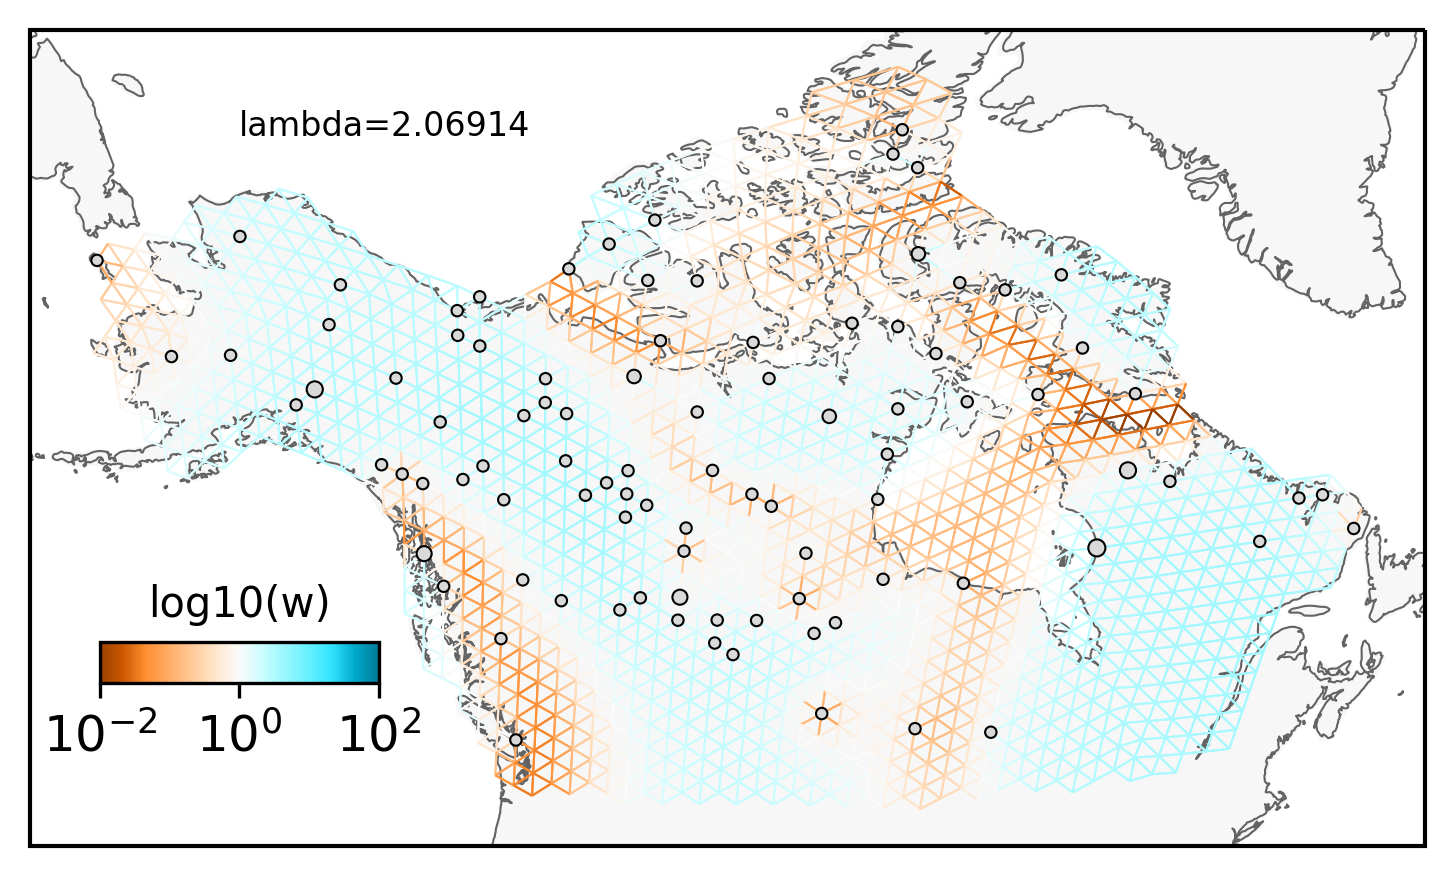

In [12]:
%%time
# figure params
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)

# figure setup
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()
ax.text(.15, .87, "lambda={:.5f}".format(lamb), 
        fontdict={"fontsize": 8}, transform = ax.transAxes)